In [11]:
import pandas as pd
from itertools import chain

,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,99
1,106,106,104,104,99,105,104,101,103,104,...,100,105,101,101,107,101,101,103,101,105
2,113,112,113,107,106,108,109,110,105,107,...,108,105,105,103,108,104,103,110,106,106
3,117,114,120,114,116,120,115,116,117,117,...,120,105,108,103,113,109,106,113,112,109
4,121,130,128,122,118,125,129,125,121,128,...,128,108,110,104,117,112,107,119,116,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,0,0,0,342,383,416,477,509,539,...,0,0,0,0,0,0,0,0,0,841
997,0,0,0,0,325,373,408,449,509,525,...,0,0,0,0,0,0,0,0,0,841
998,0,0,0,0,319,365,407,438,490,504,...,0,0,0,0,0,0,0,0,0,841
999,0,0,0,0,313,362,387,434,474,486,...,0,0,0,0,0,0,0,0,0,841


In [203]:
def get_values(path):
    df = pd.read_csv(path, skiprows=18)
    df = df.drop(columns="[all run data]")
    df.columns = range(1, len(df.columns)+1)
    df = df[500:].mean()
    return df

values = get_values("evaporation temp-intensity-spreadsheet.csv")
values

1       768.425150
2        22.504990
3       798.169661
4       258.632735
5       820.880240
           ...    
1496      0.000000
1497      0.000000
1498      0.000000
1499    647.612774
1500    647.063872
Length: 1500, dtype: float64

In [205]:
import csv


def get_params(path):
    df = pd.DataFrame()
    with open(path) as csvfile:
        spamreader = csv.reader(csvfile)
        for i, row in enumerate(spamreader):
            if i < 6:
                continue
            if i >= 17:
                break
#             print(row)
            col = pd.Series(row[1:])
            try:
                col = pd.to_numeric(col)
            except ValueError:
                pass
            df[row[0]] = col.convert_dtypes()
    return df

params = get_params("evaporation temp-intensity-spreadsheet.csv")
params

,[run number],global-temperature,mean-rain-duration,forest-evap-mul,forest-capacity-mul,[reporter],[final],[min],[max],[mean],[steps]
0,1,4,1,0.5,2,count trees,707,100,836,649.330669,1000
1,2,4,1,1.0,2,count trees,0,0,276,78.177822,1000
2,3,4,2,0.5,2,count trees,757,100,841,683.107892,1000
3,4,4,2,1.0,2,count trees,191,100,388,230.007992,1000
4,5,4,3,0.5,2,count trees,773,100,841,720.958042,1000
...,...,...,...,...,...,...,...,...,...,...,...
1495,1496,18,48,1.0,2,count trees,0,0,237,28.695305,1000
1496,1497,18,49,0.5,2,count trees,0,0,272,60.957043,1000
1497,1498,18,49,1.0,2,count trees,0,0,264,59.7003,1000
1498,1499,18,50,0.5,2,count trees,793,100,793,497.270729,1000


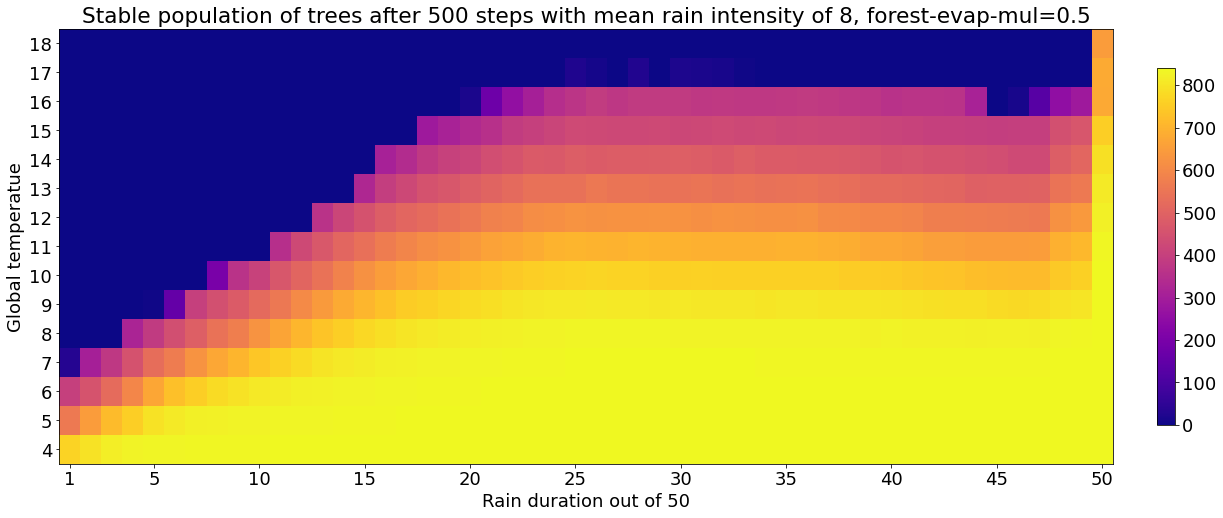

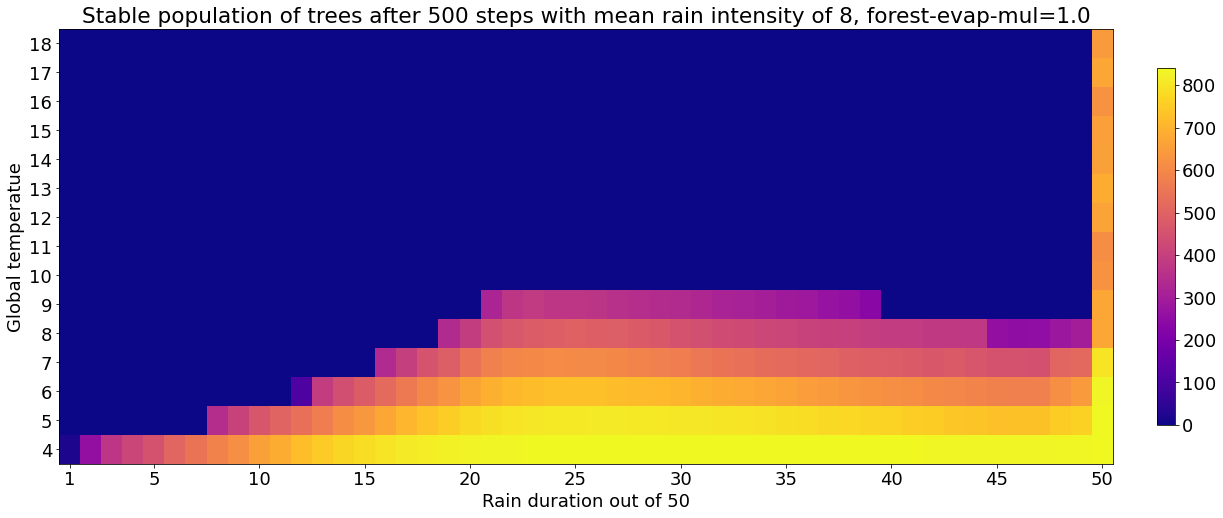

In [216]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rc('font', size=18) 


def get_index(ser):
    return {x: i for i, x in enumerate(sorted(ser.unique()))}


def to_matrix(values, params, valindex, xcol, ycol):
    xindex = get_index(params[xcol])
    yindex = get_index(params[ycol])
    
    mats = {}
    for evap_mul, rest_params in params.groupby("forest-evap-mul"):
#         print(evap_mul)
        mat = np.zeros((len(yindex), len(xindex)))
        for param in rest_params.iloc:
            val = values.loc[param[valindex]]
            x = xindex[param[xcol]]
            y = yindex[param[ycol]]
            mat[y, x] = val
        mats[evap_mul] = mat
    
    return mats, xindex, yindex

def to_imgmat(mat):
    mat -= mat.min()
    mat *= 256/mat.max()
    mat = mat.astype(np.uint8)
    return mat

def to_img(mat):
    im = Image.fromarray(np.uint8(cm.gist_earth(myarray)*255))

    
def make_matrixes():
    mats, xindex, yindex = to_matrix(values, params, "[run number]", "mean-rain-duration", "global-temperature")
    for evap_mul, mat in mats.items():
        title = f"Stable population of trees after 500 steps with mean rain intensity of 8, forest-evap-mul={evap_mul}"
        make_matrix(mat, title, xindex, yindex)
#     mat = to_imgmat(mat)
# img = to_img(mat)


def make_matrix(mat, title, xindex, yindex):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(mat, cmap="plasma", origin="lower", aspect="auto")
#     print(ax.axes.get_ylabels())
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(yindex))))
    ax.yaxis.set_ticklabels(list(yindex.keys()))
    
    plt.colorbar(cax, fraction=0.0160, pad=0.04)
    
    ax.axes.set_title(title)
    ax.axes.set_ylabel("Global temperatue")
    ax.axes.set_xlabel("Rain duration out of 50")
    
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    
#     ax.axes.set_xticks([x + 1 for x in ax.axes.get_xticks().tolist()[1:-1]])
    ax.axes.set_xticks([0, *range(4, 50, 5)])
    ax.axes.set_xticklabels([1, *range(5, 51, 5)])

make_matrixes()